sim set-up:

In [108]:
from reframed import Community, Environment
from reframed import load_cbmodel, FBA, plot_flux_envelope

#load all models
CAL2 = load_cbmodel("../GEMs/CAL2.xml", flavor="bigg")
SAL9 = load_cbmodel("../GEMs/SAL9.xml", flavor="bigg")
MAM2 = load_cbmodel("../GEMs/MAM2.xml", flavor="bigg")
MRA = load_cbmodel("../GEMs/MRA.xml", flavor="bigg")

In [112]:
# knock out glucose and xylose in k12 and bl21 strains respectivly by removing their uptake reaction

CAL11 = CAL2.copy()
CAL11.set_flux_bounds('R_GLCpts', 0, 0)
CAL11.id = "CAL11"

MAM3 = MAM2.copy()
MAM3.set_flux_bounds('R_GLCpts', 0, 0)
MAM3.id = "MAM3"

SAL11 = SAL9.copy()
SAL11.set_flux_bounds('R_XYLtex', 0, 0)
SAL11.id = "SAL11"

In [113]:
# impose constraints on SAL9 reactions so that the model cannot go crazy with the loop

SAL11.reactions.R_HPPHD.set_flux_bounds(0, float("inf"))
SAL11.reactions.R_DHPPSA.set_flux_bounds(0, float("inf"))
SAL11.reactions.R_DLDH.set_flux_bounds(float("-inf"), 0)
SAL11.reactions.R_HPLSA.set_flux_bounds(0, float("inf"))

# likewise on the MRA model
MRA.reactions.R_HPPHD.set_flux_bounds(0, float("inf"))
MRA.reactions.R_DHPPSA.set_flux_bounds(0, float("inf"))
MRA.reactions.R_DLDH.set_flux_bounds(float("-inf"), 0)
MRA.reactions.R_HPLSA.set_flux_bounds(0, float("inf"))

In [114]:
# build community object
community = Community('RA_community', [CAL11, SAL11, MAM3])
merged_community = community.merge_models()

# get medium
medium = Environment.from_model(CAL2).apply(merged_community, exclusive=True, inplace=False)
# add xylose to the medium
medium["R_EX_xyl__D_e"] = (-10, float("inf"))

## Max theoretical RA production

### standard FBA

In [125]:
FBA_sol = FBA(merged_community, constraints=medium, objective='R_EX_rosma_e')
print(FBA_sol)
FBA_sol.show_values(pattern="R_EX", sort="True")

Objective: 4.72466814159292
Status: Optimal

R_EX_o2_e    -15.5066
R_EX_xyl__D_e -10
R_EX_glc__D_e -10
R_EX_rosma_e  4.72467
R_EX_h_e      9.44934
R_EX_co2_e    24.956
R_EX_h2o_e    67.478


- model is utilising both xylose and glucose, and is therefore able to produce more RA

<AxesSubplot: xlabel='Community growth rate', ylabel='R_EX_rosma_e'>

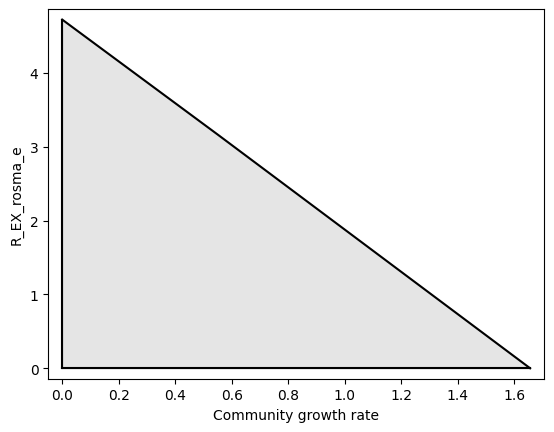

In [126]:
from reframed import plot_flux_envelope

plot_flux_envelope(merged_community, merged_community.biomass_reaction, 'R_EX_rosma_e', constraints=medium)

### SteadyCom

In [127]:
import updated_steadycom

sc_com_som = updated_steadycom.SteadyCom(community, constraints=medium, objective="R_EX_rosma_e")
print("RA production rate: ", sc_com_som.values["R_EX_rosma_e"])

RA production rate:  0.0011361904076264973


## Relative species abundance

experimental data:

         time  subpopulation_percentage strain
8   60.016004                  0.171697  CAL11
17  60.016004                  0.715428  SAL11
26  60.016004                  0.107159   MAM3


<AxesSubplot: xlabel='time', ylabel='subpopulation_percentage'>

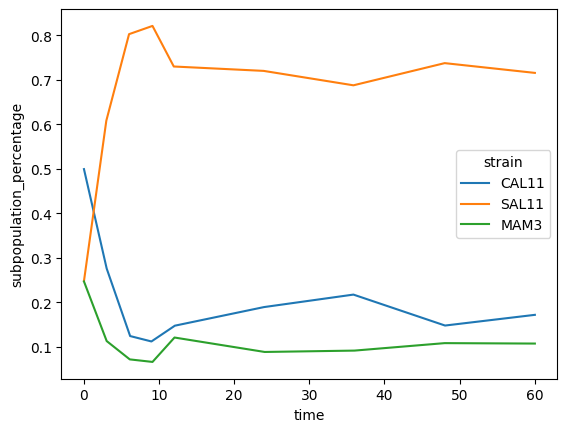

In [132]:
import pandas as pd
import seaborn as sns

relative_percentage = pd.read_csv("exp_data/subpop_data_xyl_glc.csv")

end_time = relative_percentage.time.max().round(0)
print(relative_percentage[relative_percentage["time"].round(0) == end_time])

sns.lineplot(relative_percentage, x="time", y="subpopulation_percentage", hue="strain", hue_order=["CAL11", "SAL11", "MAM3"])

  0%|          | 0/11 [00:00<?, ?it/s]

Text(0.5, 0, 'fraction of optimal solution')

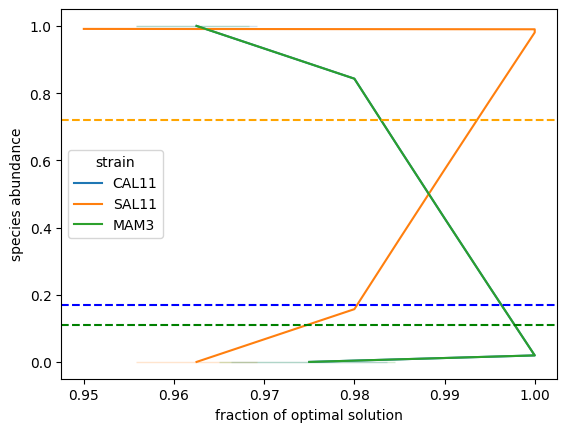

In [133]:
from reframed import SteadyComVA
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

results_list = []

#for i in tqdm(range(950, 1001, 1)):
for i in tqdm(range(950, 1005, 5)):
    frac = i/1000
    com_fva_solution = SteadyComVA(community, constraints=medium, obj_frac=frac)
    com_fva_solution["frac"] = frac
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list)
results_df.set_index("frac")

plot_df = results_df.explode(["CAL11", "SAL11", "MAM3"])
df_melt = plot_df.melt('frac', var_name='strain', value_name='species abundance')

sns.lineplot(data=df_melt, x="frac", y="species abundance", hue="strain",orient="y")

#stipled lines with exp. steady-state species abundance
plt.axhline(y=0.17, linestyle='--', color='blue')
plt.axhline(y=0.72, linestyle='--', color='orange')
plt.axhline(y=0.11, linestyle='--', color='green')

plt.xlabel("fraction of optimal solution")

- results can be replicated a 99% of optimum - a little before solution deteriorates

## Relative species abundance for different levels of RA production

In [138]:
import updated_steadycom
from reframed import SteadyComVA
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

num_points = 11

sc_com_som = updated_steadycom.SteadyCom(community, constraints=medium, objective="R_EX_rosma_e")
max_RA = sc_com_som.values["R_EX_rosma_e"]

RA_vals = np.linspace(max_RA, 0, num=num_points)

all_constraints = medium
results_list = []

# go "down" from max RA level to zero production in 10 steps and monitor the solution
for i in tqdm(range(num_points)):
    RA_level = RA_vals[i]
    
    #update the RA reaction constraint
    all_constraints["R_EX_rosma_e"] = (RA_level, float("inf"))
    
    com_fva_solution = SteadyComVA(community, constraints=all_constraints, obj_frac=1)

    com_fva_solution["RA_prod_rate"] = RA_level
    #com_fva_solution["RA_percentage"] = 100 - i*(num_points-1)
    results_list.append(com_fva_solution)

results_df = pd.DataFrame(results_list)
results_df["RA_percentage"] = np.linspace(100, 0, num_points)

  0%|          | 0/11 [00:00<?, ?it/s]

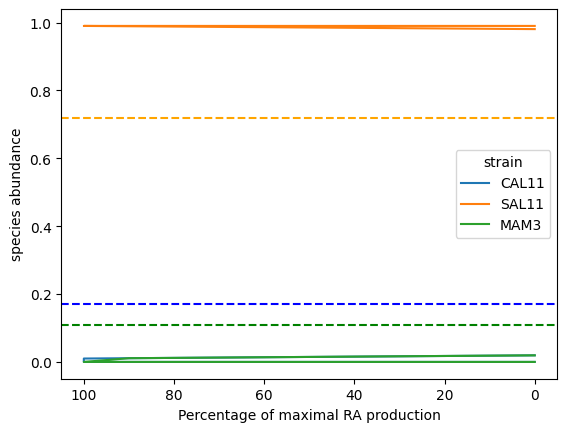

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = results_df.explode(["CAL11", "SAL11", "MAM3"])
df_melt = plot_df.drop(columns=["RA_prod_rate"]).melt('RA_percentage', var_name='strain', value_name='species abundance')

#sns.lineplot(data=df_melt, x="RA_prod_rate", y="species abundance", hue="strain",orient="y")
sns.lineplot(data=df_melt, x="RA_percentage", y="species abundance", hue="strain",orient="y")

#stipled lines with exp. steady-state species abundance
plt.axhline(y=0.17, linestyle='--', color='blue')
plt.axhline(y=0.72, linestyle='--', color='orange')
plt.axhline(y=0.11, linestyle='--', color='green')

plt.xlabel("Percentage of maximal RA production")

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

- hmm